5th notebook. Phylogenetic divergence correlations

In [62]:
import pandas as pd
from skbio import DistanceMatrix
from skbio.stats.distance import mantel
from qiime2 import Artifact
from qiime2.plugins.taxa.methods import filter_table
from qiime2.plugins.diversity_lib.methods import weighted_unifrac
import rpy2, os
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
datapath = '../data'
bombusMeta =pd.read_csv(os.path.join(datapath, 'bombusMetadata.tsv'), sep = '\t', index_col=0)

# Calculate correlations between genus-specific B-diversity and host phylogeny

## Setup

read feature tables, rooted tree 

In [2]:
level6 = pd.read_csv(os.path.join(datapath, 'table', 'genus_table.tsv'), index_col=0, sep = '\t').transpose()
mt = Artifact.load(os.path.join(datapath, 'qiime/mt.qza'))
taxa = pd.read_csv(os.path.join(datapath, 'table', 'ensemble_taxa.tsv'), index_col=0, sep = '\t')
rooted_tree=Artifact.load(os.path.join(datapath,'qiime/rooted_tree.qza'))

/Users/markyoung/miniforge3/envs/bombus/lib/python3.10/site-packages/qiime2/core/cache.py:468: UserWarning: Your temporary cache was found to be in an inconsistent state. It has been recreated.
  warnings.warn(


Only want to run testing on genera found in >10% of samples, pull them out

In [3]:
#found in 10%
withstrains = set(list((level6 >0).sum()[(level6 >0).sum() > level6.shape[0]*.1].index))
#genus
withstrains = [x for x in withstrains if 'g__' in x]
fullnames = withstrains.copy()
#shortname
withstrains = list(map(lambda x: x.split('__')[-1], withstrains))


calculate weighted unifrac for taxa-specific fractions of the microbiome

In [4]:
def printline(x):
    cols = taxa.loc[x].dropna().index
    return ';'.join([str.lower(c[0]) +'__' +taxa.loc[x, c] for c in cols])
prefixes = pd.DataFrame.from_dict({x: printline(x) for x in taxa.index}, orient = 'index',
                       columns = ['fullname'])
allcol = set(mt.view(pd.DataFrame).columns)
tables = {withstrains[i]: mt.view(pd.DataFrame)[list(allcol.intersection(\
         set(prefixes[prefixes['fullname'].str.startswith(fullnames[i])].index)))] for i in range(len(fullnames))}
tables = {c: tables[c].loc[tables[c][tables[c].sum(axis=1) > 0].index] for c in tables}

tables = {c: Artifact.import_data('FeatureTable[Frequency]', tables[c]) for c in tables}

# weighted unifrac 
wus = {c: weighted_unifrac(tables[c],
        phylogeny = rooted_tree) for \
      c in tables}
wus = { c: wus[c].distance_matrix.view(DistanceMatrix) for c in wus}

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

ssu -i /var/folders/_p/0rhlx8c56pgffwnwkjz824s80000gn/T/qiime2/markyoung/data/87fc3b7b-6af7-43af-9ab1-2e248373c3ac/data/feature-table.biom -t /var/folders/_p/0rhlx8c56pgffwnwkjz824s80000gn/T/qiime2/markyoung/data/35876f5c-5417-4221-bf1a-99b079937b5e/data/tree.nwk -m weighted_unnormalized -o /var/folders/_p/0rhlx8c56pgffwnwkjz824s80000gn/T/qiime2/markyoung/processes/91898-1742928675.162113@markyoung/tmp/q2-OutPath-5v857ka8

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

ssu -i /var/folders/_p/0rhlx8c56pgffwnwkjz824s80000gn/T/qiime2/markyoung/data/19a1ffee-fb21-4946-bcf8-3b79c

read in the host data

In [113]:
dm_host =pd.read_csv( '../data/dm/dm_host.tsv', index_col=0, sep = '\t')
dm_host = DistanceMatrix(dm_host[dm_host.index], ids = dm_host.index)

dm_sp =pd.read_csv( '../data/dm/dm_host.tsv', index_col=0, sep = '\t')
sp_samps = {}
for s in bombusMeta['species'].unique():
    sp_samps[bombusMeta[bombusMeta['species'] == s].index[0]] = s
dm_sp =dm_sp.loc[sp_samps.keys(), sp_samps.keys()].rename(index = sp_samps, columns = sp_samps)

## test for correlations

pos corr = OTU similarity proportional to host phylogenetic similarity

**1. mantel tests for spearman correlation**

In [ ]:
mantel_corrs = {c: mantel(wus[c], dm_host, strict=False) for c \
                in wus}
mantel_corrs = pd.DataFrame.from_dict(mantel_corrs, orient = 'index', 
                      columns = ['corr', 'p', 'n_samples']).sort_values(by='p')
mantel_corrs.dropna(inplace =True)
from statsmodels.stats.multitest import multipletests

mantel_corrs['fdr'] = multipletests(mantel_corrs['p'], method='fdr_bh')[1]


In [40]:
mantel_corrs[mantel_corrs['fdr']<0.05]

,corr,p,n_samples,fdr
Bombiscardovia,0.302924,0.001,355,0.003750
Bifidobacterium,0.359560,0.001,254,0.003750
Schmidhempelia,0.156091,0.001,584,0.003750
Lactobacillus,0.225078,0.001,262,0.003750
GWA2-37-10,0.125152,0.001,453,0.003750
gbxid5846,0.678599,0.001,69,0.003750
Fructobacillus,0.202769,0.001,344,0.003750
Gilliamella,0.430488,0.001,617,0.003750
Saccharibacter,0.095688,0.002,149,0.006667
Entomomonas,0.159707,0.003,220,0.009000


### re-test with stratification by collection site 
- requires R package vegan

write data

In [52]:
if not os.path.isdir('../data/table/mantel'):
    os.mkdir('../data/table/mantel')
nosite = bombusMeta[bombusMeta['site_collapsed'].str.contains('No_Site')].index
for c in wus:
    temp = wus[c].to_data_frame().copy()
    temp.columns = ['x' + x for x in temp.columns]
    temp.drop(list(set(temp.index).intersection(set(nosite))), inplace=True )
    temp.index = ['x' + x for x in temp.index]
    
    temp.to_csv('../data/table/mantel/'+c+'.tsv', sep ='\t')

make index names in the host dm R-safe

In [12]:
dm_host = dm_host.to_data_frame()
dm_host.columns = ['x' + x for x in dm_host.columns]
dm_host.index = ['x' + x for x in dm_host.index]

Read in metadata, get site strata

In [13]:
bombusMeta = pd.read_csv('../data/BombusMetadata.tsv', sep='\t',
                        index_col=0)
strata = bombusMeta['site_year']
strata.index = ['x' + x for x in strata.index]


Read into R, calculate, write

In [14]:
%load_ext rpy2.ipython

In [15]:
if not os.path.isdir('../data/table/mantel_results'):
    os.mkdir('../data/table/mantel_results')

In [53]:
%%R -i dm_host,strata

library(vegan)

for (c in list.files(path = "../data/table/mantel")){
    dm <- read.table(paste0("../data/table/mantel/", c))
    res <- mantel(dm, dm_host[rownames(dm), colnames(dm)], strata = strata[rownames(dm)])
    sink(paste0('../data/table/mantel_results/', c))
    print(res$statistic)
    print(res$signif)
    sink()    
}


11 significant, after stratification and FDR correction

In [84]:
pms = pd.concat([pd.read_csv(os.path.join('../data/table/mantel_results', x), sep =' ',
    header = None)[[1]].transpose().rename(index = {1: x.split('.tsv')[0]},
    columns = {0: 'r', 1:'p'}) for x in os.listdir('../data/table/mantel_results') if \
          x.endswith('tsv')])
pms.dropna(inplace=True)
pms['fdrbh'] = sm.stats.multipletests(pms['p'],
                       method = 'fdr_bh', is_sorted=False,
                       returnsorted=False, alpha=0.1)[1]
pms.sort_values(by ='p')

,r,p,fdrbh
Bifidobacterium,0.356095,0.001,0.003750
gbxid5846,0.674623,0.001,0.003750
Fructobacillus,0.201391,0.001,0.003750
Gilliamella,0.428982,0.001,0.003750
Bombiscardovia,0.302859,0.001,0.003750
Asaia,0.248155,0.001,0.003750
Lactobacillus,0.221430,0.001,0.003750
Schmidhempelia,0.155399,0.001,0.003750
Saccharibacter,0.093070,0.002,0.006667
Entomomonas,0.159707,0.004,0.012000


In [85]:
pms[pms['fdrbh'] < 0.05].sort_values(by='r', ascending=False)

,r,p,fdrbh
gbxid5846,0.674623,0.001,0.003750
Gilliamella,0.428982,0.001,0.003750
Bifidobacterium,0.356095,0.001,0.003750
Bombiscardovia,0.302859,0.001,0.003750
Asaia,0.248155,0.001,0.003750
Lactobacillus,0.221430,0.001,0.003750
Fructobacillus,0.201391,0.001,0.003750
Entomomonas,0.159707,0.004,0.012000
Schmidhempelia,0.155399,0.001,0.003750
Saccharibacter,0.093070,0.002,0.006667


## 2 way plot

In [ ]:
alltables = []
for t in pms[pms['fdrbh'] < 0.05].index:

    test = tables[t].view(pd.DataFrame)
    missing_ids = [id for id in bombusMeta.index if id not in test.index]
    test = pd.concat([test, pd.DataFrame(np.nan,index=missing_ids, columns=test.columns)]).fillna(0)
    test = test.join(bombusMeta[['species']]).groupby('species').mean()
    test = test.loc[optimal_order]
    test_dm = np.abs((1- test.dropna(axis=0).corr(method ='pearson'))/2) #abs incase fp error 
    test_link = sch.linkage(squareform(test_dm), method='average')
    test_order =sch.leaves_list(sch.optimal_leaf_ordering(test_link, squareform(test_dm)))
    alltables.append(test[test_dm.columns[test_order]])
alltables = pd.concat([x.T for x in alltables]).T

In [146]:
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform

linkage_matrix = sch.linkage(squareform(dm_sp), method='average')
optimal_order = sch.leaves_list(sch.optimal_leaf_ordering(linkage_matrix, squareform(dm_sp)))
optimal_order = dm_sp.iloc[optimal_order].index

species_colors = pcoa(dm_sp).samples.set_index(dm_sp.index)[['PC1']]
import matplotlib.pyplot as plt
import numpy as np

norm = plt.Normalize(species_colors['PC1'].min(), species_colors['PC1'].max())
colormap = plt.cm.Spectral(norm(species_colors['PC1']))
species_colormap =dict(zip(species_colors.index, colormap))



In [259]:
pms.join(pd.DataFrame.from_dict({x: (tables[x].view(pd.DataFrame) > 0).sum(axis=1).mean() for x in tables}, 
                orient='index', columns = ['mean_strains']).sort_values(by='mean_strains', ascending=False))

,r,p,fdrbh,mean_strains
Bifidobacterium,0.356095,0.001,0.003750,1.610236
gbxid5846,0.674623,0.001,0.003750,1.043478
Fructobacillus,0.201391,0.001,0.003750,1.825581
Gilliamella,0.428982,0.001,0.003750,2.361426
Bombiscardovia,0.302859,0.001,0.003750,1.016901
Asaia,0.248155,0.001,0.003750,1.150685
Lactobacillus,0.221430,0.001,0.003750,1.213740
Schmidhempelia,0.155399,0.001,0.003750,1.186644
Saccharibacter,0.093070,0.002,0.006667,1.677852
Entomomonas,0.159707,0.004,0.012000,1.304545


In [252]:
pms.join(pd.DataFrame.from_dict({x: tables[x].view(pd.DataFrame).shape[1] for x in tables}, 
                orient='index', columns = ['ASVs'])).join(\
        pd.DataFrame.from_dict({x: tables[x].view(pd.DataFrame).shape[0] for x in tables}, 
                orient='index', columns = ['Samples'])).to

,r,p,fdrbh,ASVs,Samples
Bifidobacterium,0.356095,0.001,0.003750,27,254
gbxid5846,0.674623,0.001,0.003750,5,69
Fructobacillus,0.201391,0.001,0.003750,30,344
Gilliamella,0.428982,0.001,0.003750,65,617
Bombiscardovia,0.302859,0.001,0.003750,8,355
Asaia,0.248155,0.001,0.003750,8,73
Lactobacillus,0.221430,0.001,0.003750,19,262
Schmidhempelia,0.155399,0.001,0.003750,41,584
Saccharibacter,0.093070,0.002,0.006667,20,149
Entomomonas,0.159707,0.004,0.012000,18,220


/Users/markyoung/miniforge3/envs/bombus/lib/python3.10/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:146: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.003715094750531212 and the largest is 0.20250338132866696.
  warn(
/Users/markyoung/miniforge3/envs/bombus/lib/python3.10/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:146: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for m

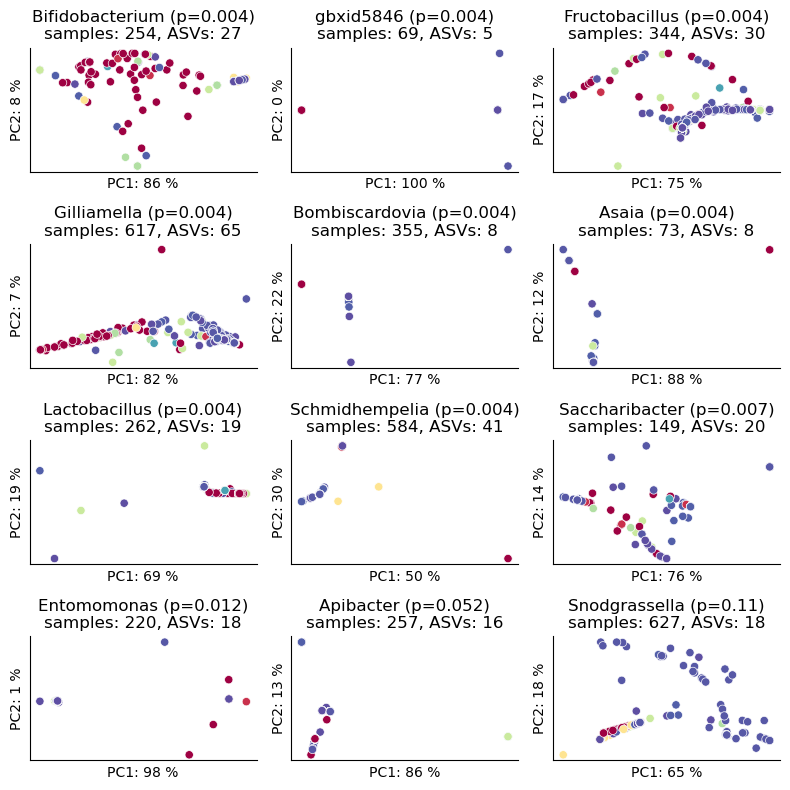

In [253]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

pms = pms.sort_values(by = 'p')
fig, ax = plt.subplots(4,3, figsize = (8, 8))
for i in range(12):
    y = i % 3
    x = i // 3

    test = pcoa(wus[pms.index[i]].data)
    test.samples.index = tables[pms.index[i]].view(pd.DataFrame).index
    test.samples = test.samples[['PC1', 'PC2']].join(bombusMeta['species'])
    sns.scatterplot(data = test.samples, x = 'PC1', y = 'PC2', hue ='species',
                    palette = species_colormap, hue_order = species_colors.sort_values(by = 'PC1').index,
                    ax = ax[x,y], legend = False)


    
    
    ax[x,y].set_title(pms.index[i] + ' (p=' + str(round(pms.loc[pms.index[i], 'fdrbh'], 3))+ ')'\
                       + '\nsamples: ' + str(test.samples.shape[0]) + ', ASVs: ' + str(tables[pms.index[i]].view(pd.DataFrame).shape[1]))
    ax[x,y].set_xticks([])
    ax[x,y].set_yticks([])
    ax[x,y].set_xlabel('PC1: ' + str(round( test.proportion_explained['PC1'] * 100) ) + ' %')
    ax[x,y].set_ylabel('PC2: ' + str(round(test.proportion_explained['PC2'] * 100) ) + ' %')
sns.despine()
plt.tight_layout()
fig.savefig('figs/ASV_PCoA.pdf',
               format = 'pdf', transparent = True, bbox_inches='tight')

In [185]:
test.samples.dropna()

,PC1,PC2,species
B0004,-0.000065,-0.000065,imp
B0005,-0.000065,-0.000065,imp
B0009,-0.000065,-0.000065,bor
B0013,-0.000065,-0.000065,vag
B0015,-0.000065,-0.000065,bim
...,...,...,...
PF190724_006,-0.000065,-0.000065,vag
PF190724_007,-0.000065,-0.000065,imp
PF190724_008,-0.000065,-0.000065,bim
RGA190718_001,-0.000065,-0.000065,tern


In [204]:
test.proportion_explained

PC1     0.999925
PC2     0.000075
PC3     0.000000
PC4     0.000000
PC5     0.000000
          ...   
PC65    0.000000
PC66    0.000000
PC67    0.000000
PC68    0.000000
PC69    0.000000
Length: 69, dtype: float64

/Users/markyoung/miniforge3/envs/bombus/lib/python3.10/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:146: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -8.819026080463656e-07 and the largest is 0.012639913247927723.
  warn(


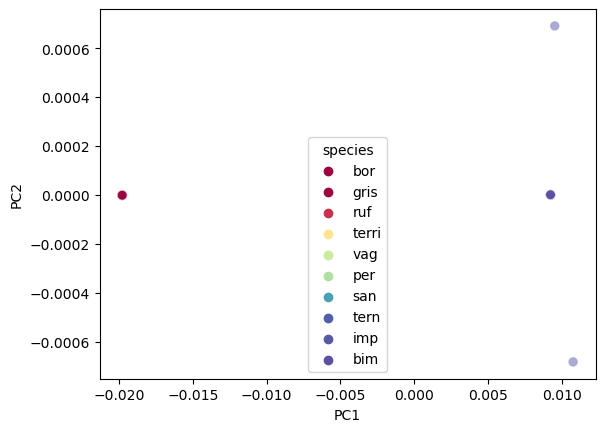

In [230]:
from skbio.stats.ordination import pcoa
fig, ax = plt.subplots()
test = pcoa(wus['gbxid5846'].data)
test.samples.index = tables['gbxid5846'].view(pd.DataFrame).index
test.samples = test.samples[['PC1', 'PC2']].join(bombusMeta['species'])
sns.scatterplot(data = test.samples, x = 'PC1', y = 'PC2', hue ='species',
                 palette = species_colormap, hue_order = species_colors.sort_values(by = 'PC1').index,
                 s=50, alpha = 0.5)
fig.savefig('figs/random_pcoa_with_legend.pdf',
               format = 'pdf', transparent = True, bbox_inches='tight')



<Axes: xlabel='UMAP1', ylabel='UMAP2'>

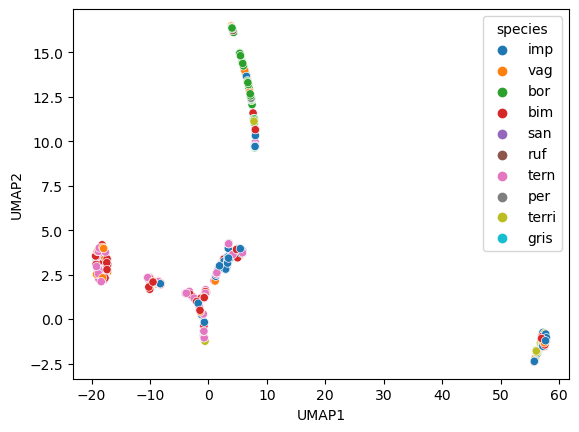

In [218]:
umap_df = umap_df.join(bombusMeta[['species']])
sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='species')

<Axes: >

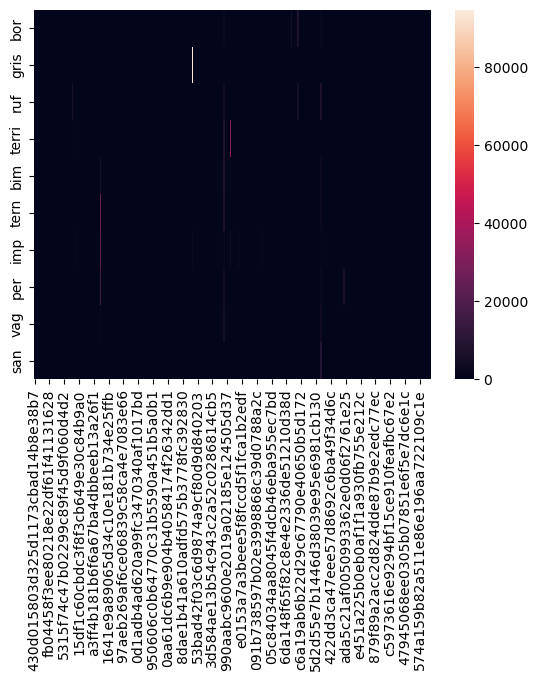

In [186]:
sns.heatmap(alltables)

In [196]:
pms.sort_values(by ='r', ascending=False)

,r,p,fdrbh
gbxid5846,0.674623,0.001,0.003750
Gilliamella,0.428982,0.001,0.003750
Bifidobacterium,0.356095,0.001,0.003750
Bombiscardovia,0.302859,0.001,0.003750
Asaia,0.248155,0.001,0.003750
Lactobacillus,0.221430,0.001,0.003750
Fructobacillus,0.201391,0.001,0.003750
Entomomonas,0.159707,0.004,0.012000
Schmidhempelia,0.155399,0.001,0.003750
Pantoea,0.144960,0.120,0.225000


In [59]:
pms = pd.concat([pd.read_csv(os.path.join('../data/table/mantel_results', x), sep =' ',
    header = None)[[1]].transpose().rename(index = {1: x.split('.tsv')[0]},
    columns = {0: 'r', 1:'p'}) for x in os.listdir('../data/table/mantel_results') if \
          x.endswith('tsv')])
pms['fdrbh'] = sm.stats.multipletests(pms['p'],
                       method = 'fdr_bh', is_sorted=False,
                       returnsorted=False, alpha=0.1)[1]
pms.sort_values(by ='p')

,r,p,fdrbh
Saccharibacter,0.121421,0.001,0.009333
Bifidobacterium,0.433609,0.001,0.009333
Gilliamella,0.291820,0.001,0.009333
Asaia,0.259559,0.007,0.049000
Allorhizobium-Neorhizobium-Pararhizobium-Rhizobium,0.132430,0.061,0.264000
Apibacter,0.080329,0.065,0.264000
Fructobacillus,0.007226,0.066,0.264000
Leuconostoc,0.010602,0.084,0.294000
Spiroplasma,0.140529,0.096,0.298667
Chloroplast,0.107898,0.147,0.411600


# Barplot of OTU reulative abundances

**calculate cumulative sum of average relative abundances of OTUs**

In [60]:
tables = {c: tables[c].filtered_table.view(pd.DataFrame) for c in tables}
tables = pd.concat([(tables[x].transpose() /tables[x].sum(axis=1)\
            ).dropna().mean(axis=1).sort_values(ascending=False\
    ).reset_index().drop(columns='index').transpose().rename({0:x}) for \
          x in tables])
tables = tables.sort_values(by = 0, ascending=False).fillna(0)
tables = tables.transpose().cumsum().transpose()
tables = tables.reset_index().reset_index()

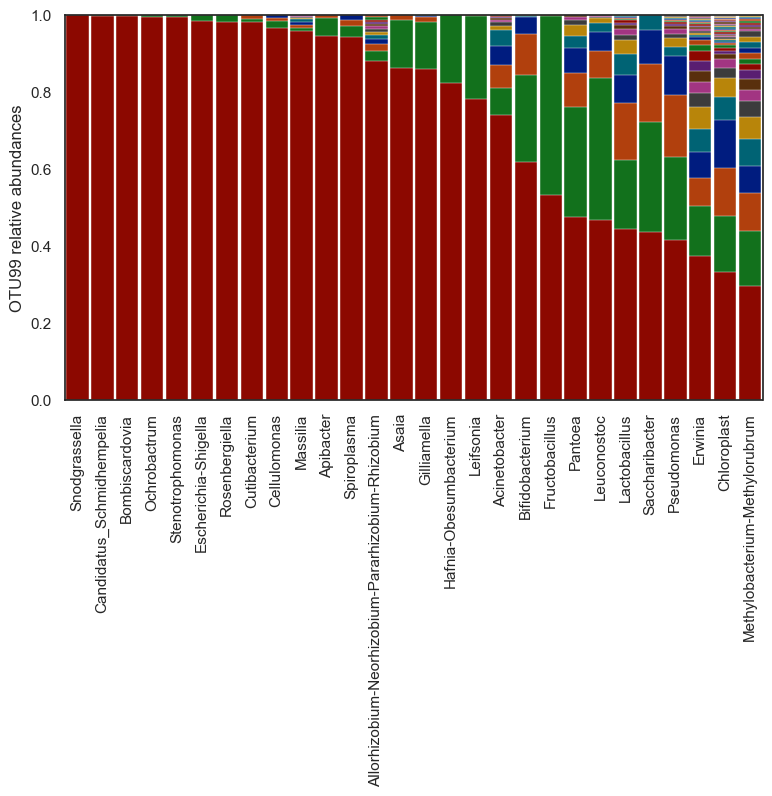

In [71]:
sns.set(style = 'white', palette = 'dark')
fig, ax = plt.subplots(figsize = (9, 5))
for i in np.arange(53, -1, -1):
    plt.bar(x = tables['level_0'], height = tables[i], 
           linewidth=0.3, alpha = 1, width=.9)
plt.xticks(tables['level_0'], labels = tables['index'], rotation = 90)
plt.xlim(-.5, 27.5)
plt.ylim(0,1)
plt.ylabel('OTU99 relative abundances')
plt.show()
fig.savefig('figs/OTU_barplot.pdf',
               format = 'pdf', transparent = True, bbox_inches='tight')

# ball and stick plots

In [5]:
tables = {withstrains[i]: mt.view(pd.DataFrame)[list(allcol.intersection(\
         set(prefixes[prefixes['fullname'].str.startswith(fullnames[i])].index)))] for i in range(len(fullnames))}
tables = {c: tables[c].loc[tables[c][tables[c].sum(axis=1) > 0].index] for c in tables}

/var/folders/_p/0rhlx8c56pgffwnwkjz824s80000gn/T/ipykernel_91898/103207507.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_species))  # Get a colormap with enough colors


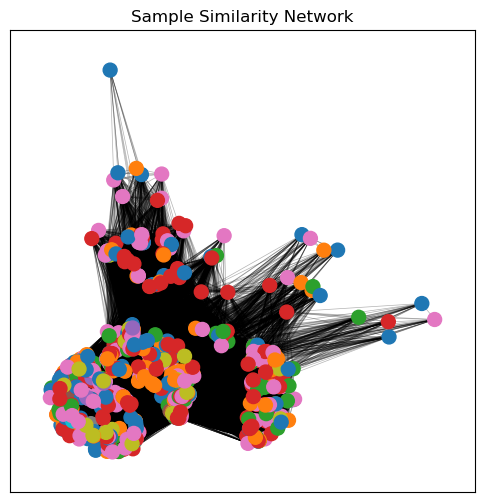

In [111]:
similarity_matrix = np.array((tables['Gilliamella'] > 0).astype(int).dot(tables['Gilliamella'].T > 0))
to_species = bombusMeta.loc[tables['Gilliamella'].index].reset_index()['species']
unique_species = to_species.unique()
colors = plt.cm.get_cmap('tab10', len(unique_species))  # Get a colormap with enough colors
species_color_map = {species: colors(i) for i, species in enumerate(unique_species)}
node_colors = [species_color_map[species] for species in to_species]


import networkx as nx
import matplotlib.pyplot as plt
import numpy as np


num_samples = similarity_matrix.shape[0]

# Create graph
G = nx.Graph()
for i in range(num_samples):
    for j in range(i + 1, num_samples):
        if similarity_matrix[i, j] > 0:
            G.add_edge(i, j, weight=similarity_matrix[i, j])

# Compute positions using spring layout (edge weight as inverse distance)
pos = nx.spring_layout(G, weight='weight')

# Draw nodes
plt.figure(figsize=(6, 6))
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=100)

# Draw edges with thickness proportional to shared strains
edges = G.edges(data=True)
nx.draw_networkx_edges(
    G, pos, edgelist=[(u, v) for u, v, d in edges],
    width=[d['weight'] / 2 for _, _, d in edges], alpha=0.3
)

# Draw labels

plt.title("Sample Similarity Network")
plt.show()


# Tree with heatmap

In [234]:
bombusMeta['species'].unique()
tofullname = {'imp': 'B._impatiens', 'vag': 'B._vagans',
    'bor': 'B._borealis', 'bim': 'B._bimaculatus', 'san': 'B._sandersoni',
    'ruf': 'B._rufocinctus', 'tern': 'B._ternarius', 'per': 'B._perplexus',
    'terri': 'B._terricola', 'gris': 'B._griseocollis'}


In [233]:
tree = Phylo.read('../data/tree', 'newick')
tree.get_terminals()

[Clade(branch_length=0.0038607859, name='Ps._citrinus'),
 Clade(branch_length=0.005902272, name='Ps._variabilis'),
 Clade(branch_length=0.0047964896, name='Ps._insularis'),
 Clade(branch_length=0.040064353, name='Ps._fernaldae'),
 Clade(branch_length=0.028768735, name='Ps._ashtoni'),
 Clade(branch_length=0.018173665, name='B._fervidus'),
 Clade(branch_length=0.0294881854, name='B._pennsylvanicus'),
 Clade(branch_length=0.082680576, name='B._borealis'),
 Clade(branch_length=0.016558325, name='B._ternarius'),
 Clade(branch_length=0.018560885, name='B._impatiens'),
 Clade(branch_length=0.038780164, name='B._bimaculatus'),
 Clade(branch_length=0.031785518, name='B._perplexus'),
 Clade(branch_length=0.017692171, name='B._frigidus'),
 Clade(branch_length=0.018232072, name='B._sandersoni'),
 Clade(branch_length=0.034537878, name='B._vagans'),
 Clade(branch_length=0.0157307, name='B._neoboreus'),
 Clade(branch_length=0.010748593, name='B._balteatus'),
 Clade(branch_length=0.005238045, name='B.

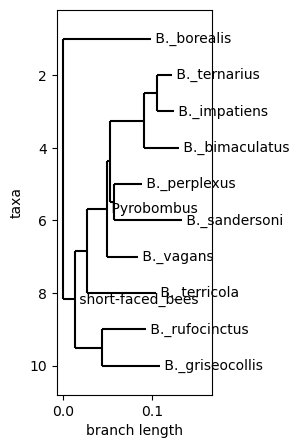

In [235]:
from Bio import Phylo

tree = Phylo.read('../data/tree', 'newick')
filtered_tree = tree
for clade in tree.get_terminals():
    if clade.name not in tofullname.values():
        filtered_tree.prune(clade)
fig, ax = plt.subplots(figsize=(2, 5))

Phylo.draw(filtered_tree, axes = ax)

plt.show()
fig.savefig('figs/filtered_tree.pdf',
               format = 'pdf', transparent = True, bbox_inches='tight')


In [109]:
df = wus['Bombiscardovia'].to_data_frame()
df = df.reset_index().rename(columns = {'index': 's0'})
df = pd.melt(df, id_vars = ['s0'], var_name = 's1', value_name = 'weighted_unifrac')
df['species0'] = pd.merge(df, bombusMeta[['species']], left_on = 's0', right_index = True)['species'].replace(tofullname)
df['species1'] = pd.merge(df, bombusMeta[['species']], left_on = 's1', right_index = True)['species'].replace(tofullname)
df['comparison'] = df.apply(lambda x: "_".join(sorted([x['species0'], x['species1']])), axis = 1)
pd.DataFrame(df.groupby('comparison')['weighted_unifrac'].mean())


,weighted_unifrac
comparison,
B._bimaculatus_B._bimaculatus,0.000212
B._bimaculatus_B._borealis,0.004619
B._bimaculatus_B._impatiens,0.000522
B._bimaculatus_B._perplexus,0.002739
B._bimaculatus_B._rufocinctus,0.000107
B._bimaculatus_B._sandersoni,0.000107
B._bimaculatus_B._ternarius,0.000140
B._bimaculatus_B._terricola,0.000107
B._bimaculatus_B._vagans,0.000107
